In [1]:
import pandas
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.integrate import solve_ivp
from decimal import Decimal
from scipy import interpolate
from scipy.interpolate import InterpolatedUnivariateSpline

G = 6.67408e-8 # Gravitational constant in cm^3 g^-1 s-2
m_solar = 1.989e33 # Solar mass in g
r_terra = 6.371e8 # Radius of Earth in cm

def newtonian():
    
    # ~~ b ~~ #
    
    df = pandas.read_csv('white_dwarf_data.csv')
    
    # g = G*M/r^2
    df['logg'] = np.sqrt(G * m_solar * df['mass'] / 10**df['logg'])/r_terra

    df.columns = ['WD ID', 'Radius(in Earth radius)', 'Mass(in solar mass)']
    
    df = df.sort_values('Radius(in Earth radius)')
    
    # Simply a graph representing the dataset.
    plt.scatter(df['Radius(in Earth radius)'], df['Mass(in solar mass)'], label='CSV data')
    plt.title("Mass vs Radius for Low-Temperature White Dwarves")
    plt.xlabel("Radius (in Earth radius)")
    plt.ylabel("Mass (in solar mass)")
    plt.grid()
    
    plt.savefig("WD.jpg", dpi=150)
    
    
    # ~~ c ~~ #
    
    
    def expected_curve_func(R, C, n):
        return C * (R ** ((3-n)/(1-n)))

    true_rdata = df['Radius(in Earth radius)']
    true_mdata = df['Mass(in solar mass)']
    
    num_points = np.arange(30, 100, 30)
    fig, axs = plt.subplots(1, 2)
    axs[0].plot(true_rdata, true_mdata, label='Dataset')
    axs[1].loglog(true_rdata, true_mdata)
    
    def plotz(n):
        
        rdata = df['Radius(in Earth radius)'][-1:-(n+1):-1]
        mdata = df['Mass(in solar mass)'][-1:-(n+1):-1]
        
        
        
        
        axs[0].set_title("M vs R")
        axs[0].set_xlabel("Radius (in Earth radius)")
        axs[0].set_ylabel("Mass (in solar mass)")
        axs[0].grid()
            
        popt,pcov = curve_fit(expected_curve_func, rdata, mdata, bounds=([-np.inf, 1.01], [np.inf, np.inf]))
        nstar = popt[1]
        q = 5*nstar/ (1 + nstar)
        c = np.random.rand(3,)
        axs[0].plot(rdata, expected_curve_func(rdata, *popt), c = c, label="q=%.2f" % q)
        axs[0].plot(true_rdata, expected_curve_func(true_rdata, *popt), c=c, ls='--')
        
        axs[0].set_xlim(0.3, 2.8)
        axs[0].set_ylim(0, 1.5)
        
        axs[0].legend()
        
        
        axs[1].loglog(rdata, expected_curve_func(rdata, *popt), c=c)
        axs[1].set_title("log-log Dataset vs %d points(b)" % n)
        axs[1].grid()
        plt.savefig("WD_loglog.jpg", dpi=150)
        
    for n in num_points:
        plotz(n),
    

    def mass_q3(R, C):
        return C * (R ** -3)    
    
    def lane_emden(ksi, fg):
        f, g = fg
        if np.abs(ksi) <= 1e-12:
            return np.zeros(2)
        else:
            return [g, -f**1.5 - 2*g/ksi]
    
    
    sol = solve_ivp(lane_emden, [0, 5], [1, 0], t_eval = np.linspace(0, 5, 300))
    
    ksi_n = sol.t[-1]
    dtheta_n = sol.y[1, -1]
    N_n = ((4 * np.pi) ** (-2)) * (2.5 ** 3) * (-ksi_n**2 * dtheta_n) * (ksi_n**3)
    
    scaled_rdata = df['Radius(in Earth radius)'].to_numpy()
    scaled_mdata = df['Mass(in solar mass)'].to_numpy()
    
    def mass2(R, C):
        return C * R**(-3)
    
    n = 40
        
    rdata = scaled_rdata[-1:-(n+1):-1]
    mdata = scaled_mdata[-1:-(n+1):-1]
   
    fig, axs = plt.subplots()
        
    popt, pcov = curve_fit(mass2, rdata, mdata)
    
    print(popt[0])
    
    Kstar = np.cbrt(popt[0] * (m_solar * G**3) / (r_terra**(-3) * N_n))
    
    axs.plot(rdata, mass2(rdata, *popt), 'r', label="K*=%.2E" % Decimal(Kstar))
    axs.plot(scaled_rdata, scaled_mdata, 'b')
    axs.plot(scaled_rdata, mass2(scaled_rdata, *popt), 'r--')
    
    axs.set_xlim(0.3, 2.8)
    axs.set_ylim(0, 1.5)
    
    axs.set_title("Mass vs Radius - Dataset & low-mass Prediciton")
    axs.set_xlabel("Radius (in Earth radius)")
    axs.set_ylabel("Mass (in Solar mass)")
    
    axs.grid()
    axs.legend()
    plt.savefig("WD_DatvPrd.jpg", dpi=150)
    
    rho_c = scaled_mdata * m_solar * (ksi_n**3) / (4 * np.pi * (scaled_rdata * r_terra)**3 * (-ksi_n**2 * dtheta_n))
    
    df['rhoc'] = rho_c
    
    df2 = df.sort_values(by=['Mass(in solar mass)'])
    sorted_mdata = df2['Mass(in solar mass)']
    sorted_rhodata = df2['rhoc']
        
    mdata = sorted_mdata[:n]
    rhodata = sorted_rhodata[:n]
    
    popt2, pcov2 = curve_fit(lambda x, C: C*(x**2), mdata, rhodata)
   
    
    print(popt2)
    
    print(m_solar**2 * G**3 * ksi_n**3 / (Kstar**3 * 4 * np.pi * N_n * (-ksi_n**2 * dtheta_n)))
    
    fig, axs = plt.subplots()
    axs.plot(sorted_mdata, sorted_rhodata, 'b', label="Dataset")
    axs.plot(mdata, popt2[0] * mdata**2, 'r', label="$M^2$ fit")
    axs.plot(sorted_mdata, popt2[0] * sorted_mdata**2, 'r--')
    axs.set_xlim(0, 0.6)
    axs.set_ylim(0, 2e6)
    axs.set_title("Central density vs $M^2$ fit for low mass")
    axs.set_xlabel("Mass (in Solar mass)")
    axs.set_ylabel("Central density (in g$cm^{-3}$)")
    
    axs.grid()
    axs.legend()
    plt.savefig("WD_Dense.jpg", dpi=150)

    # ~~ d ~~ #
    
    rho_c_orig = 1e5
    rho_c_upper = 1e9

    def solve_ivp_wd(d, rhoc):
        D = d
        rho_c = rhoc
        Kstar = 3.04e12
        def hydro_eq(r, mrho):
            m, rho = mrho
            if r==0:
                return [0, rho_c]
            return [4 * np.pi * r**2 * rho,
                    -3 * G * (rho**(1/3)) * np.sqrt(1 + ((rho/D)**(2/3))) * m / (5 * Kstar * r**2)]
        def ende(r, mrho):
            return mrho[1]
       
        ende.terminal = True
    
        ende.direction = -1
        
        return solve_ivp(hydro_eq, [0, 1e14], [0, rho_c], events=ende)


    D_lower_bound = 2e6
    D_upper_bound = 3e6
    
    grand_num_trials = 50
    
    Ds = np.linspace(D_lower_bound, D_upper_bound, grand_num_trials)
    
    errors = np.zeros((grand_num_trials, 2))

    num_trials = 20
    
    fig, axs = plt.subplots()
    
    axs.plot(scaled_rdata, scaled_mdata, 'b', label='Dataset')
    
    rhos = np.geomspace(rho_c_orig, rho_c_upper, num_trials)

    for j in range(0, grand_num_trials):
        
        D = Ds[j]
        
        masses = np.zeros((num_trials, 2))
        
        for i in range (0, num_trials):
            sol = solve_ivp_wd(D, rhos[i])
            
            actual_rdata = sol.t[-1]
            actual_mdata = sol.y[0, -1]
            
            # print(actual_mdata)
            # print(actual_rdata)
            
            masses[i] = [actual_rdata, actual_mdata]
        
        
        
        calculated_rdata = masses[:, 0] / r_terra
        calculated_mdata = masses[:, 1] / m_solar
        
        spl = InterpolatedUnivariateSpline(calculated_rdata[::-1], calculated_mdata[::-1])
        
        error = np.sqrt(np.sum((scaled_mdata - spl(scaled_rdata)) ** 2))
        
        errors[j] = [D, error]
    
    # Finding the D value with the lowest error and using it
    df2 = pandas.DataFrame(errors, columns=['D', 'Error'])
    df2.sort_values(by = 'Error', inplace=True)
    ds = df2['D'].to_numpy()
    lowest_error_d = ds[0]
    
    print(lowest_error_d)
        
    for i in range (0, num_trials):
        
        sol = solve_ivp_wd(lowest_error_d, rhos[i])
        
        actual_rdata = sol.t[-1]
        actual_mdata = sol.y[0, -1]
        
        # print(actual_mdata)
        # print(actual_rdata)
        
        masses[i] = [actual_rdata, actual_mdata]
    
        axs.plot(actual_rdata/r_terra, actual_mdata/m_solar, 'o', color='red')
    
    
        calculated_rdata = masses[:, 0] / r_terra
        calculated_mdata = masses[:, 1] / m_solar
        
        #print(calculated_rdata[:1:-1])
        
        
    spl = InterpolatedUnivariateSpline(calculated_rdata[::-1], calculated_mdata[::-1])
    
    print(np.abs(scaled_mdata - spl(scaled_rdata)))
    print("C* = %.2E" % Decimal(5 * Kstar * lowest_error_d ** (5/3) / 8))
    
    axs.plot(scaled_rdata, spl(scaled_rdata), 'r', label='Numerical Solution')
    axs.set_title("Mass v Radius - Dataset vs Numerical Solution")
    axs.set_xlabel("Radius (in Earth radius)")
    axs.set_ylabel("Mass (in Solar mass)")
    
    axs.legend()
    axs.grid()
    plt.savefig("WD_DatvSol.jpg", dpi=150)
    
    
    
    # ~~ e ~~ #
    
    fig, axs = plt.subplots()
    
    def solve_ivp_wd(d, rhoc):
        D = d
        rho_c = rhoc
        Kstar = 3.04e12
        def hydro_eq(r, mrho):
            m, rho = mrho
            if r==0:
                return [0, rho_c]
            return [4 * np.pi * r**2 * rho,
                    -3 * G * (rho**(1/3)) * np.sqrt(1 + ((rho/D)**(2/3))) * m / (5 * Kstar * r**2)]
        def ende(r, mrho):
            return mrho[1]
        
        ende.terminal = True
    
        ende.direction = -1
        
        return solve_ivp(hydro_eq, [0, 1e14], [0, rho_c], events=ende)    
    
    num_trials = 200
        
    rhos = np.geomspace(1e10, 1e15, num_trials)
    
    masses = np.zeros((num_trials, 2))
    
    for i in range (0, num_trials):
        
        sol = solve_ivp_wd(2e6, rhos[i])
        
        actual_rdata = sol.t[-1]
        actual_mdata = sol.y[0, -1]

        masses[i] = [actual_rdata, actual_mdata]       
        
    
    #axs.plot(masses[:, 0] / r_terra, masses[:, 1] / m_solar)
        
    #df3 = pandas.DataFrame({'mdata': masses[:, 1] / m_solar, 'rdata' : masses[:, 0] / r_terra}) 
    
    #df3.set_index('mdata', inplace=True) 
    
    #df3.sort_index(ascending = False, inplace = True)
    
    #print(df3.head())
    
    #axs.set_title("Mass v Radius limit test")
    #axs.set_xlabel("Radius (in Earth radius)")
    #axs.set_ylabel("Mass (in Solar mass)")
    
    #axs.grid()
    #plt.savefig("WD_limit.jpg", dpi=150)
    
    
    
    

<ipython-input-1-ec82888231de>:93: RuntimeWarning: invalid value encountered in double_scalars
  return [g, -f**1.5 - 2*g/ksi]


2.025170358116403
[5320711.53288664]
5410304.212008059


<ipython-input-1-ec82888231de>:182: RuntimeWarning: invalid value encountered in double_scalars
  -3 * G * (rho**(1/3)) * np.sqrt(1 + ((rho/D)**(2/3))) * m / (5 * Kstar * r**2)]


KeyboardInterrupt: 

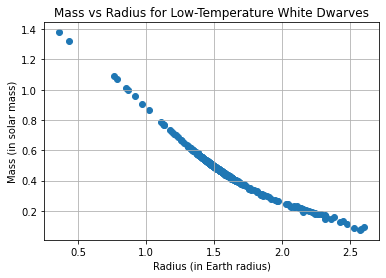

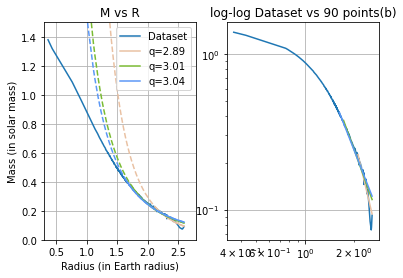

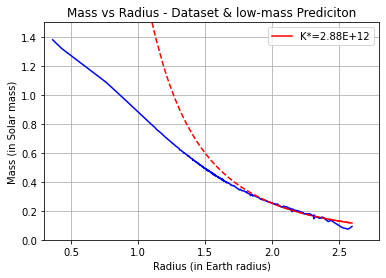

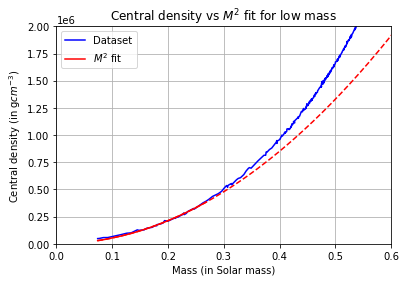

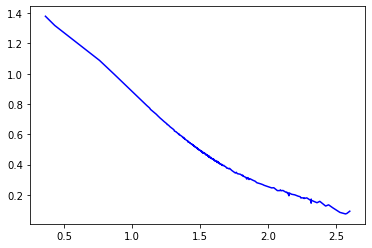

In [2]:
newtonian()